In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import reproject
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm
from shapely.geometry import box

import pandas as pd
import shapely
from tqdm import tqdm

In [2]:
# Function: move to SRC

def read_and_visualize_raster(file_path, dataset_name):
    # Open the raster file
    with rasterio.open(file_path) as src:
        # Read the raster data
        raster_data = src.read(1)
        transform = src.transform
        crs = src.crs
        
        # Calculate the extent of the raster
        extent = (transform[2], transform[2] + transform[0] * src.width,
                  transform[5] + transform[4] * src.height, transform[5])
        
        # Plot the raster data with a logarithmic color scale
        plt.figure(figsize=(10, 10))
        plt.imshow(raster_data, cmap='viridis', norm=LogNorm(), extent=extent)
        plt.colorbar(label=f'{dataset_name} (log scale)')
        plt.title(f'{dataset_name} Visualization')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

        print(f"Coordinate Reference System: {crs}")
        print(f"Raster extent: {extent}")
        #print resolution
        print(f"Resolution: {transform[0]} x {transform[4]}")

def clip_raster1_with_raster2(input_raster_path, mask_path, output_raster_path):
    # Determine if the mask is a raster or vector file
    with rasterio.open(mask_path) as mask_src:
        mask_bounds = mask_src.bounds
        mask_geom = [box(*mask_bounds)]
    
    # Open the input raster to be clipped
    with rasterio.open(input_raster_path) as src:
        # Clip the input raster with the mask geometry
        out_image, out_transform = mask(src, mask_geom, crop=True)
        out_meta = src.meta.copy()
        
        # Update the metadata with new dimensions, transform, and CRS
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        # Save the clipped raster to a new file
        with rasterio.open(output_raster_path, "w", **out_meta) as dest:
            dest.write(out_image)

def downsample_raster_by_sum(input_raster_path, output_raster_path, upscale_factor):
    with rasterio.open(input_raster_path) as dataset:
        # Calculate the new dimensions
        new_height = int(dataset.height * upscale_factor)
        new_width = int(dataset.width * upscale_factor)
        
        # Prepare the metadata for the output raster
        out_meta = dataset.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": new_height,
            "width": new_width,
            "transform": dataset.transform * dataset.transform.scale(
                (dataset.width / new_width),
                (dataset.height / new_height)
            )
        })
        
        # Create an array to hold the resampled data
        resampled_data = np.zeros((dataset.count, new_height, new_width), dtype=dataset.dtypes[0])
        
        # Perform the resampling using reproject with sum
        for i in range(1, dataset.count + 1):
            reproject(
                source=rasterio.band(dataset, i),
                destination=resampled_data[i - 1],
                src_transform=dataset.transform,
                src_crs=dataset.crs,
                dst_transform=out_meta['transform'],
                dst_crs=dataset.crs,
                resampling=Resampling.sum
            )
        
        # Save the upsampled raster to a new file
        with rasterio.open(output_raster_path, "w", **out_meta) as dest:
            dest.write(resampled_data)

def resample_raster_to_match_grid(source_raster_path, target_raster_path, output_raster_path):
    # Open the target raster to get its grid
    with rasterio.open(target_raster_path) as target:
        target_transform = target.transform
        target_crs = target.crs
        target_width = target.width
        target_height = target.height
    
    # Open the source raster to be resampled
    with rasterio.open(source_raster_path) as src:
        source_data = src.read(1)
        source_transform = src.transform
        source_crs = src.crs
        
        # Prepare the metadata for the output raster
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": target_height,
            "width": target_width,
            "transform": target_transform,
            "crs": target_crs
        })
        
        # Create an array to hold the resampled data
        resampled_data = np.empty((target_height, target_width), dtype=source_data.dtype)
        
        # Perform the resampling
        reproject(
            source=source_data,
            destination=resampled_data,
            src_transform=source_transform,
            src_crs=source_crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )
        
        # Save the resampled raster to a new file
        with rasterio.open(output_raster_path, "w", **out_meta) as dest:
            dest.write(resampled_data, 1)
            
# Clip cisi index gpd CISI_europe.feather to mask_path
def clip_geodataframe_with_raster(geodataframe_path, raster_path, output_path):
    df = pd.read_feather(geodataframe_path)
    df.geometry = shapely.from_wkb(df.geometry)
    # Convert to GeoDataFrame and set the geometry column
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    # Open the raster file and extract its bounding box
    with rasterio.open(raster_path) as src:
        bounds = src.bounds
        bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)
    
    # Clip the GeoDataFrame using the bounding box geometry
    clipped_gdf = gdf[gdf.geometry.intersects(bbox)]
    
    # Save the clipped GeoDataFrame to a Feather file
    clipped_gdf.to_feather(output_path)

In [3]:
# Make output folder if it does not exist

output_folder = "data/output/resample_pop2"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


In [7]:
# list .tif files in data folder if contain string "2010" or "2100"
pop_v2_folder = "data/population_v2"
pop_v2_file_names_list = os.listdir(pop_v2_folder)
pop_v2_2010_file_names_list = [f for f in pop_v2_file_names_list if ".tif" in f and ("2010" in f in f)]
pop_v2_2100_file_names_list = [f for f in pop_v2_file_names_list if ".tif" in f and ("2100" in f)]

print (pop_v2_2010_file_names_list)
print (pop_v2_2100_file_names_list)


['SSP5_2010_EU_UK.tif', 'SSP2_2010_EU_UK.tif', 'SSP3_2010_EU_UK.tif', 'SSP4_2010_EU_UK.tif', 'SSP1_2010_EU_UK.tif']
['SSP2_2100_EU_UK.tif', 'SSP5_2100_EU_UK.tif', 'SSP4_2100_EU_UK.tif', 'SSP3_2100_EU_UK.tif', 'SSP1_2100_EU_UK.tif']


In [4]:
# Paths population data

# Pop v1
# pop_2010_path = "data/pop/SSP2_2010_Europe.tif"
# pop_2100_path = "data/pop/SSP2_2100_Europe.tif"
# mask_path = "data/pop/SSP2_2100_EU_UK.tif"

# clipped_pop_2010_path = os.path.join(output_folder, "clipped_pop_2010.tif")
# clipped_pop_2100_path = os.path.join(output_folder, "clipped_pop_2100.tif")


crs ="EPSG:4326"

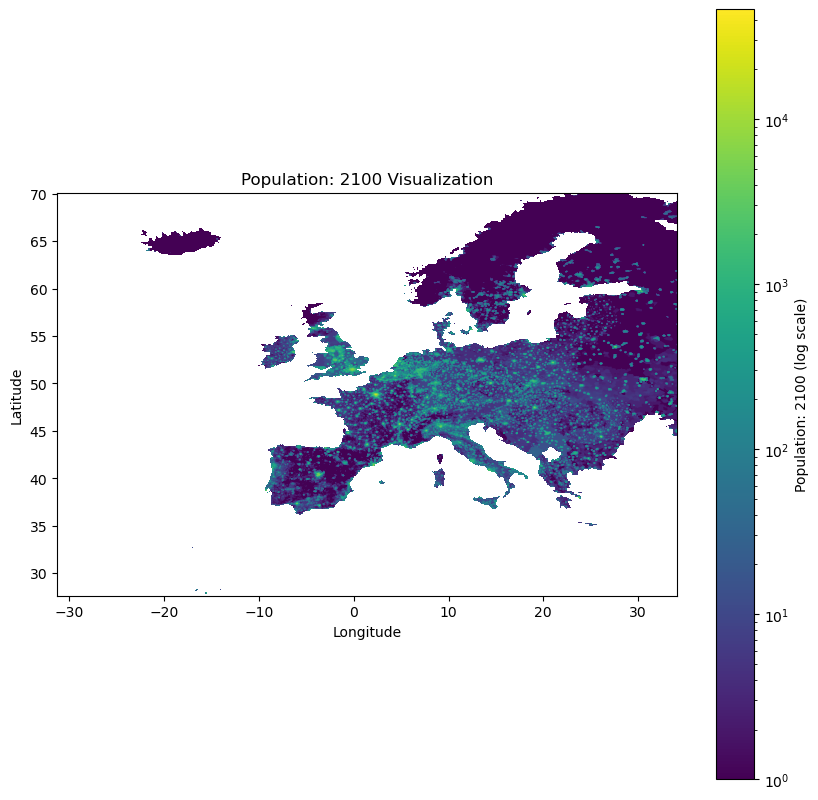

Coordinate Reference System: EPSG:4326
Raster extent: (-31.275000000000006, 34.091666666666654, 27.63333333340524, 70.09166666673858)
Resolution: 0.008333333333333333 x -0.008333333333333333


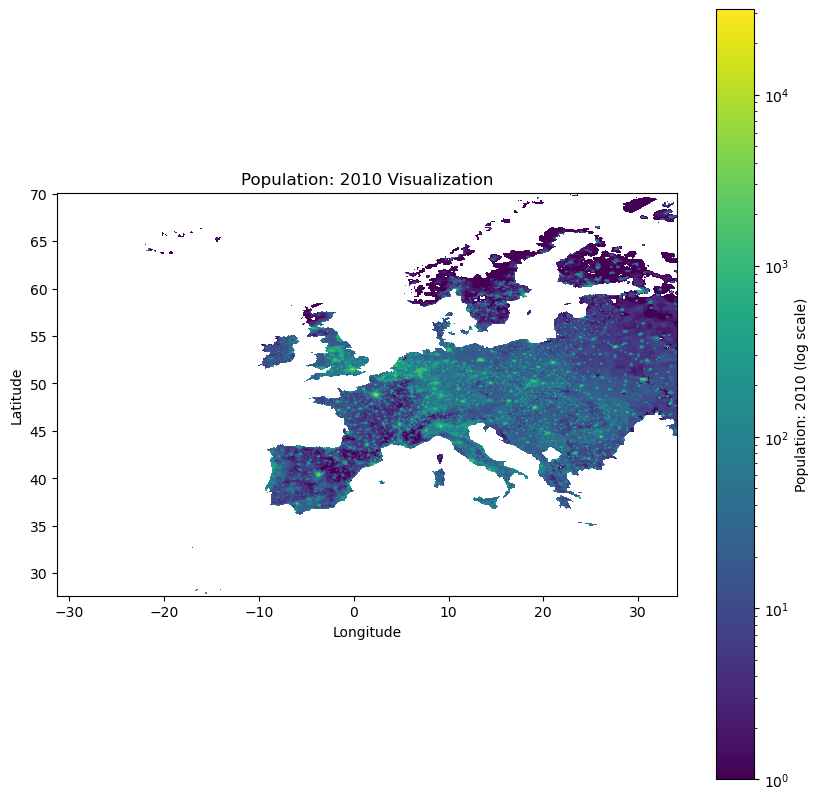

Coordinate Reference System: EPSG:4326
Raster extent: (-31.275000000000006, 34.091666666666654, 27.63333333340524, 70.09166666673858)
Resolution: 0.008333333333333333 x -0.008333333333333333


In [5]:
# Clip population raster to Europe mask

clip_raster1_with_raster2(pop_2100_path, mask_path, clipped_pop_2100_path)
read_and_visualize_raster(clipped_pop_2100_path, "Population: 2100")

clip_raster1_with_raster2(pop_2010_path, mask_path, clipped_pop_2010_path)
read_and_visualize_raster(clipped_pop_2010_path, "Population: 2010")

In [6]:
# Paths cisi index data

cisi_index_path = "data/cisi/CISI/025_degree/CISI_europe.feather"
clip_cisi_index_path = os.path.join(output_folder, "clipped_cisi_index.feather")

cisi_raster_path = "data/cisi/Amount_of_infrastructure/025_degree/primary.tif"
clip_cisi_raster_path = os.path.join(output_folder, "clipped_cisi.tif")


# summary_transportation_path = "data/cisi/Amount_of_infrastructure/025_degree/summary_transportation.feather"
# clipped_summary_transportation_path = 'data/output/summary_transportation_clipped.feather'

In [7]:
# Paths CISI absolute value data
# glob list files in folder ending with .feather
cisi_absolute_value_folder = "data/cisi/Amount_of_infrastructure/025_degree"
cisi_absolute_value_file_paths = [os.path.join(cisi_absolute_value_folder, f) for f in os.listdir(cisi_absolute_value_folder) if f.endswith('.feather')]
cisi_absolute_value_file_names = [os.path.basename(f) for f in cisi_absolute_value_file_paths]


In [8]:
# Clip CISI to Europe mask

clip_geodataframe_with_raster(cisi_index_path, mask_path, clip_cisi_index_path)
clip_raster1_with_raster2(cisi_raster_path, mask_path, clip_cisi_raster_path)

# Clip CISI absolute value to Europe mask and save to new files
for i, (file_path, file_name) in tqdm(enumerate(zip(cisi_absolute_value_file_paths, cisi_absolute_value_file_names)), desc="Clipping CISI absolute value files"):
    output_file_path = os.path.join(output_folder, file_name.replace(".feather", "_clipped.feather"))
    clip_geodataframe_with_raster(file_path, mask_path, output_file_path)

# read_and_visualize_raster(cliped_cisi_path, "Amount of Infrastructure EU: Primary transportation")
# clip_geodataframe_with_raster(summary_transportation_path, mask_path, clipped_summary_transportation_path)

Clipping CISI absolute value files: 7it [00:09,  1.29s/it]


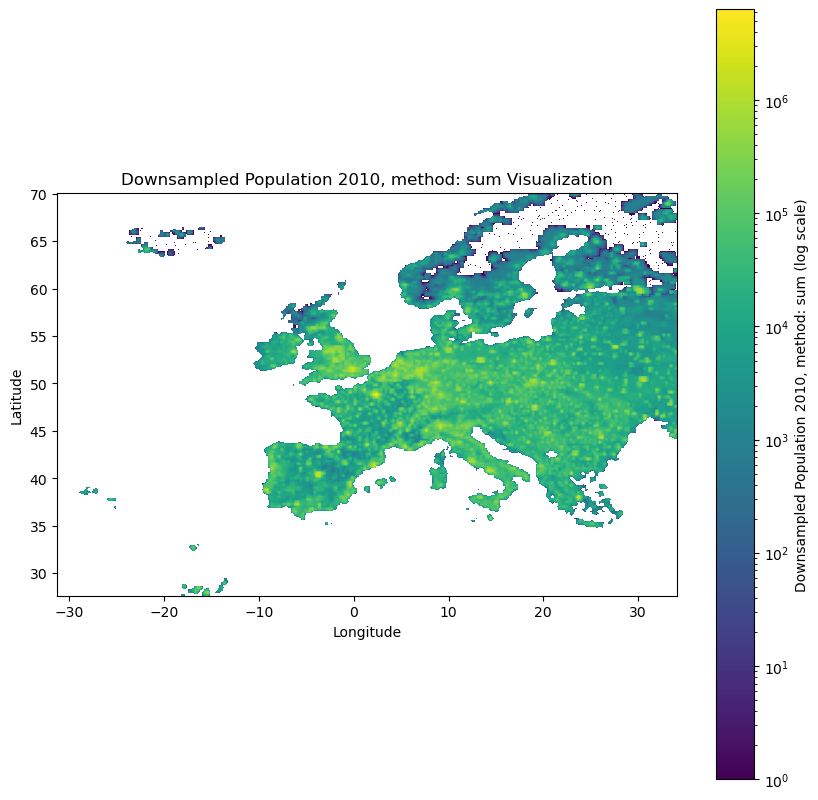

Coordinate Reference System: EPSG:4326
Raster extent: (-31.275000000000006, 34.09166666666667, 27.633333333405247, 70.09166666673858)
Resolution: 0.2504469987228608 x -0.251232741617357


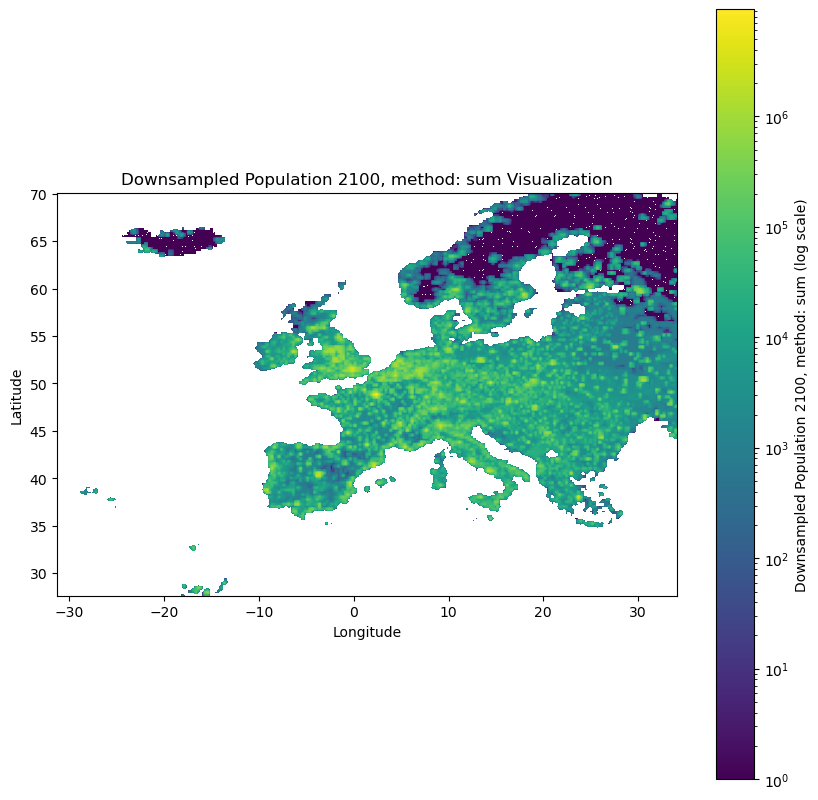

Coordinate Reference System: EPSG:4326
Raster extent: (-31.275000000000006, 34.09166666666667, 27.633333333405247, 70.09166666673858)
Resolution: 0.2504469987228608 x -0.251232741617357


In [9]:
# Downsample population to match CISI

downsample_pop_2010_path = os.path.join(output_folder, "downsampled_pop_2010.tif")
downsample_raster_by_sum(clipped_pop_2010_path  , downsample_pop_2010_path, 1/30)
read_and_visualize_raster(downsample_pop_2010_path, "Downsampled Population 2010, method: sum")

downsample_pop_2100_path = os.path.join(output_folder, "downsampled_pop_2100.tif")
downsample_raster_by_sum(clipped_pop_2100_path  , downsample_pop_2100_path, 1/30)
read_and_visualize_raster(downsample_pop_2100_path, "Downsampled Population 2100, method: sum")

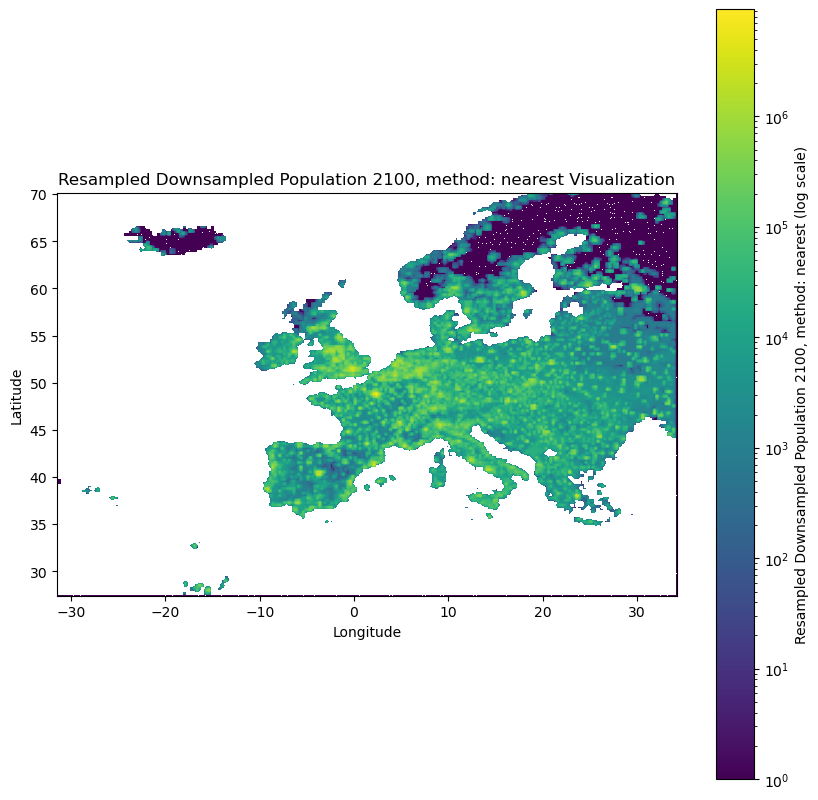

Coordinate Reference System: EPSG:4326
Raster extent: (-31.5, 34.25, 27.40833282, 70.15833282)
Resolution: 0.25 x -0.25


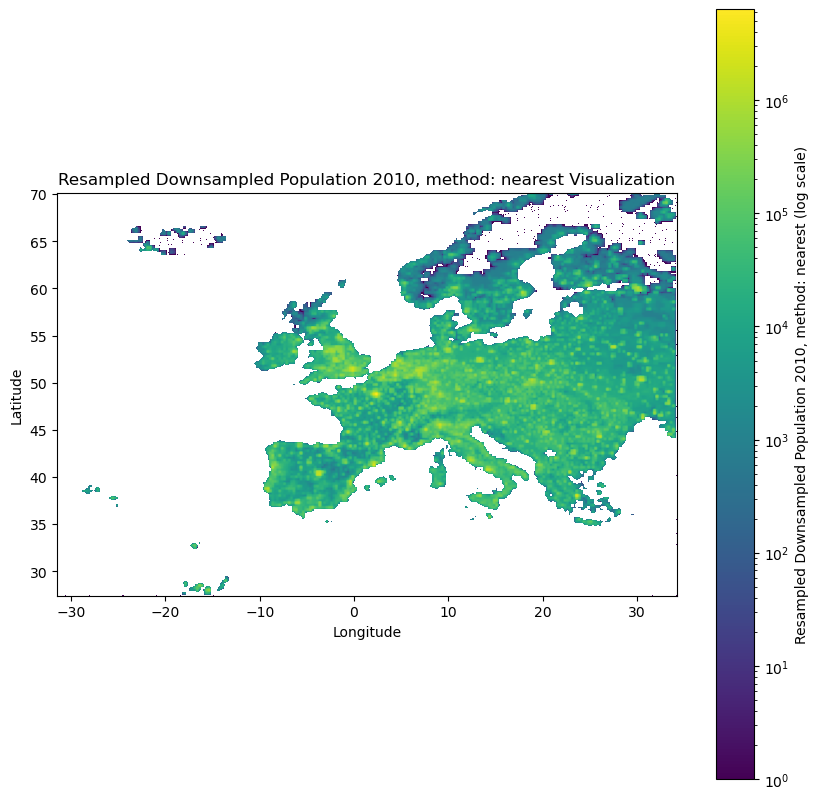

Coordinate Reference System: EPSG:4326
Raster extent: (-31.5, 34.25, 27.40833282, 70.15833282)
Resolution: 0.25 x -0.25


In [10]:
# Resample nearest to match grid of cisi raster

resample_pop_2100_path = os.path.join(output_folder, "resampled_downsampled_pop_2100.tif")
resample_raster_to_match_grid(downsample_pop_2100_path, clip_cisi_raster_path, resample_pop_2100_path)
read_and_visualize_raster(resample_pop_2100_path, "Resampled Downsampled Population 2100, method: nearest")

resample_pop_2010_path = os.path.join(output_folder, "resampled_downsampled_pop_2010.tif")
resample_raster_to_match_grid(downsample_pop_2010_path, clip_cisi_raster_path, resample_pop_2010_path)
read_and_visualize_raster(resample_pop_2010_path, "Resampled Downsampled Population 2010, method: nearest")


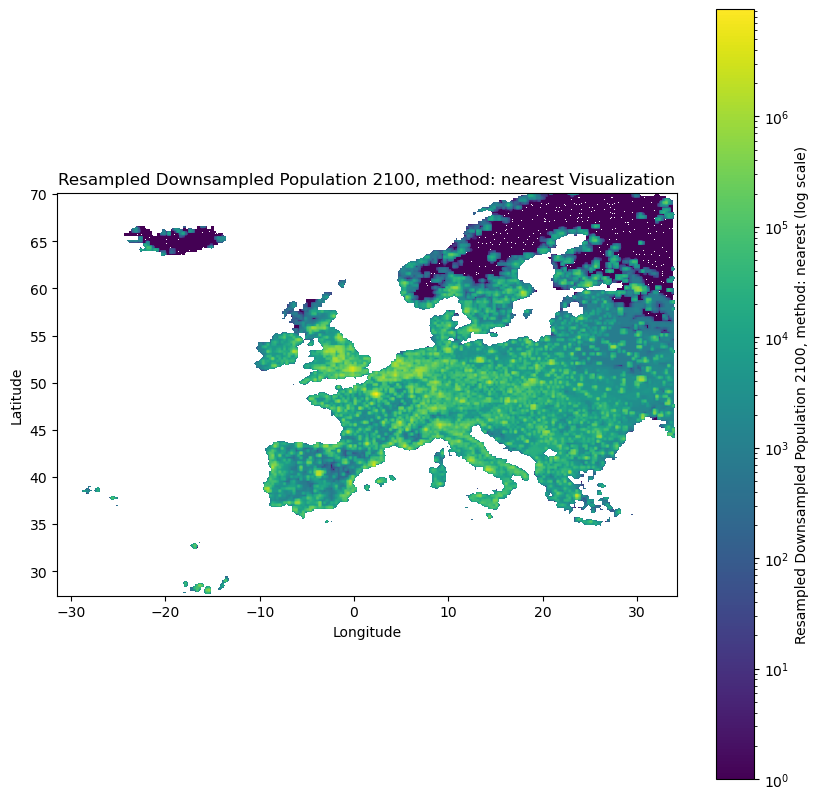

Coordinate Reference System: EPSG:4326
Raster extent: (-31.5, 34.25, 27.40833282, 70.15833282)
Resolution: 0.25 x -0.25


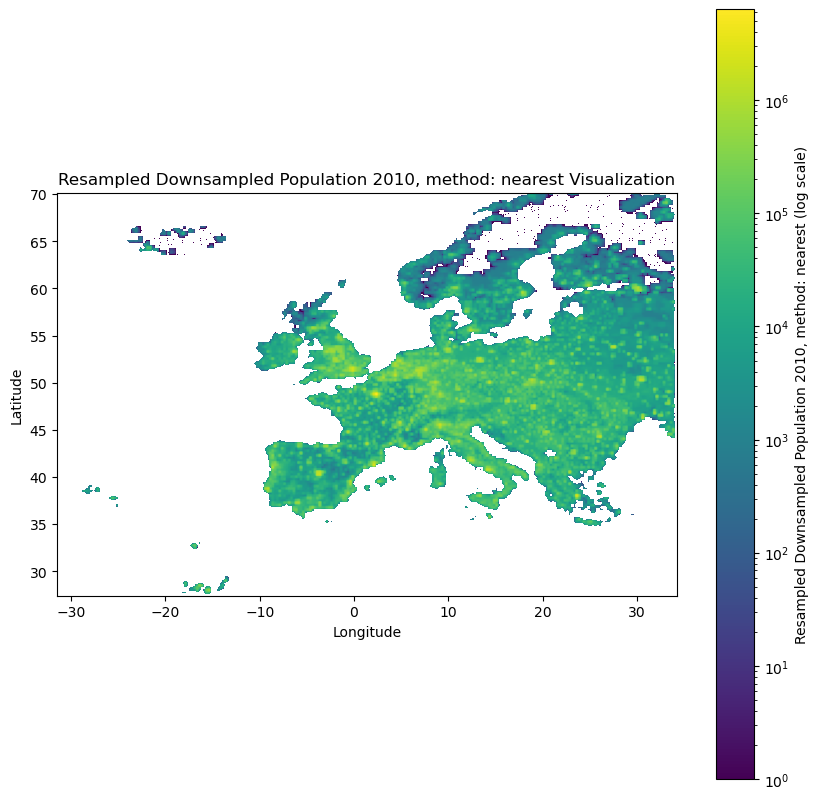

Coordinate Reference System: EPSG:4326
Raster extent: (-31.5, 34.25, 27.40833282, 70.15833282)
Resolution: 0.25 x -0.25


In [11]:
nearest_pop_2100_path = os.path.join(output_folder, "nearest_pop_2100.tif")
clip_raster1_with_raster2(resample_pop_2100_path, mask_path, nearest_pop_2100_path)
read_and_visualize_raster(nearest_pop_2100_path, "Resampled Downsampled Population 2100, method: nearest")

nearest_pop_2010_path = os.path.join(output_folder, "nearest_pop_2010.tif")
clip_raster1_with_raster2(resample_pop_2010_path, mask_path, nearest_pop_2010_path)
read_and_visualize_raster(nearest_pop_2010_path, "Resampled Downsampled Population 2010, method: nearest")
